# L11 - Uczenie reprezentacji

Na dzisiejszych zajęciach dowiemy się o paru metodach nauki reprezentacji (a nie gęstości danych), co może być przydatne do projektu (w szczególności autoenkodery).

Ref:
* (Repr. Learning, review) http://www.cl.uni-heidelberg.de/courses/ws14/deepl/BengioETAL12.pdf
* (Deep Learning book, ch. 15) http://www.deeplearningbook.org/
* (Autoenkodery w Keras) https://blog.keras.io/building-autoencoders-in-keras.html
* (Bardzo polecam, czego uczą się autoenkodery) https://gabgoh.github.io/ThoughtVectors/
* Isomap
* C-Isomap

In [6]:
import matplotlib.pylab as plt
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
%matplotlib inline

In [ ]:
import numpy as np

In [33]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model

# Zbiory danych

* Swissroll (2 -> 3)

* MNIST (? -> 784), ? pewnie nie dużo większe niż 30

* Fishbowl (2 -> 3)

In [9]:
## Swissroll
n_samples = 1500
noise = 0.05
X_swissroll, z_swissroll = make_swiss_roll(n_samples, noise)
X_swissroll[:, 1] *= .5

In [37]:
## MNIST
(x_mnist_train, _), (x_mnist_test, _) = mnist.load_data()
x_mnist_train = x_mnist_train.astype('float32') / 255.
x_mnist_test = x_mnist_test.astype('float32') / 255.
x_mnist_train = x_mnist_train.reshape((len(x_mnist_train), np.prod(x_mnist_train.shape[1:])))
x_mnist_test = x_mnist_test.reshape((len(x_mnist_test), np.prod(x_mnist_test.shape[1:])))

# Modele

In [44]:
def build_autoencoder(activation='relu', output_activation='sigmoid', hidden_dim=32, input_dim=784):
    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(hidden_dim, activation=activation)(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation=output_activation)(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded 
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

# Postawienie problemu

## Odwracanie funkcji

Z jednej strony możemy patrzeć na problem uczenia nienadzorowanego jako problemu "odwrócenia" funkcji generującej dane.

Przykładowo, punkt ze zbioru danych swissroll powstaje przez wylosowanie 2 zmiennych $u_1$ oraz $u_2$ a potem ich zanurzeniu w 3 wymiarach. Ten proces staramy się odwrócić i znaleźć (nieliniowy) układ współrzędnych w którym swissroll "jest wypłaszczony".

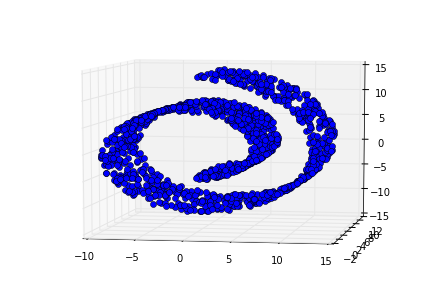

In [31]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.plot3D(X_swissroll[:,0], X_swissroll[:, 1], X_swissroll[:, 2], 'o')

<img width=300 src="figures/L11/swissroll.png">

## Maximum likelihood

Z drugiej strony popularnym podejściem jest stawianie problemu uczenia nienadzorowanego jako znajdowania rozwiązania 

$$ \theta^{*} = argmax_{\theta} \mathbb{E}[p_\theta(x)] $$

Co istotne, jeśli naszym celem jest nauka cech (a nie aproksymacja gęstości), to nie ma zadnych gwarancji że podejścia typu "maximum likelihood" nauczą się ciekawych cech, patrz np. http://www.inference.vc/maximum-likelihood-for-representation-learning-2/.

# PCA / liniowy autonkoder

Najprostsza sieć neuronowa do nauki cech jednocześnie implementuje PCA ("In the auto-associative case ... and therefore the unique locally and globally optimal map W is the orthogonal projection onto the space spanned by the first pp eigenvectors of ΣXX").

<img src="figures/L11/autoencoder_schema.jpg" width=500>

Dla liniowej funkcji enkoder metoda znajduje to samo co PCA:

<img src="figures/L11/pca.png" width=500>

In [42]:
autoencoder, encoder, decoder = build_autoencoder(activation='linear', output_activation='sigmoid',
                                                 hidden_dim=32, input_dim=784)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
58880/60000 [============================>.] - ETA: 0s - loss: 0.3657

KeyboardInterrupt: 

## Problemy PCA / liniowego autoenkodera

* Brak modelu prawdopodobieństwa (0 poza nieskończonie małym podzbiorem) - Probabilistic PCA, patrz np. http://edwardlib.org/tutorials/probabilistic-pca oraz VAE/denoising autoenckoder
* Zakłada globalną strukture euklidesową - MDS generalizuje na dowolną metryke
* Zakłada globalną strukturę liniową - Isomap/LLE/kernelPCA/nieliniowe autoenkodery wszystkie rozwiązać ten problem

# Isomap oraz LLE

"PCA
finds a low-dimensional embedding of the
data points that best preserves their variance
as measured in the high-dimensional input
space. Classical MDS finds an embedding
that preserves the interpoint distances, equivalent
to PCA when those distances are Euclidean.
However, many data sets contain
essential nonlinear structures that are invisible
to PCA and MDS (4, 5, 11, 14). For
example, both methods fail to detect the true
degrees of freedom of the face data set (Fig.
1A), or even its intrinsic three-dimensionality
(Fig. 2A)." (http://wearables.cc.gatech.edu/paper_of_week/isomap.pdf)

# t-SNE

t-SNE służy do wizualizacji, nie nauki cech! Ale jest zamieszczony ze względu na ogromną popularność.

# Nieliniowy autoenkoder

Ref: http://gabgoh.github.io/ThoughtVectors/

TODO: Pokazac na fishbowl co robi PCA, AE

# O czym nie wspominamy

* Klastrowanie (w szczególności spectral clustering)
* GAN 
* kernel PCA / probabilistic PCA

# Algebra na reprezentacji

In [14]:
# TODO: Rozwiązać similarity za pomocą word embeddingów

# TODO: Wykres analogy word embeddingów

# Zadanie [3 pkt]

Zaimplementuj rozwiązywanie analogii za pomocą word-embeddingów. 